## This notebook reloads previously saved models and prints the evaluation for comparison

In [4]:
# Imports
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
import os

# Constants
TARGET_VAR = "dx"
IMAGE_SIZE = (64, 64)

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/' 

TARGET_LABEL="dx"
BALANCE_LABEL="dx"
IMAGE_SIZE = (224, 224)

In [5]:
MODEL_PATH = "../models/"
MODEL_NAME = "model_2023-09-27_VGG16_1000images_30epochs.h5"

In [6]:
# Load test_df from file
test_df = pd.read_csv("../data/processed/test_from_Metadata_processed.csv")

In [8]:
#preprocess the test images into BGR format
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=32
)

Found 2003 validated image filenames belonging to 7 classes.


In [7]:
# List all the models in MODEL_PATH
model_list = os.listdir(MODEL_PATH)

# just keep elements with -h5 extension
model_list = [model for model in model_list if model[-3:] == ".h5"]


In [9]:
VGG16_model = tf.keras.models.load_model(MODEL_PATH + MODEL_NAME)

63/63 [==============================] - 681s 11s/step - loss: 20.0888 - accuracy: 0.4518
Restored model, accuracy: 45.18%
63/63 [==============================] - 690s 11s/step


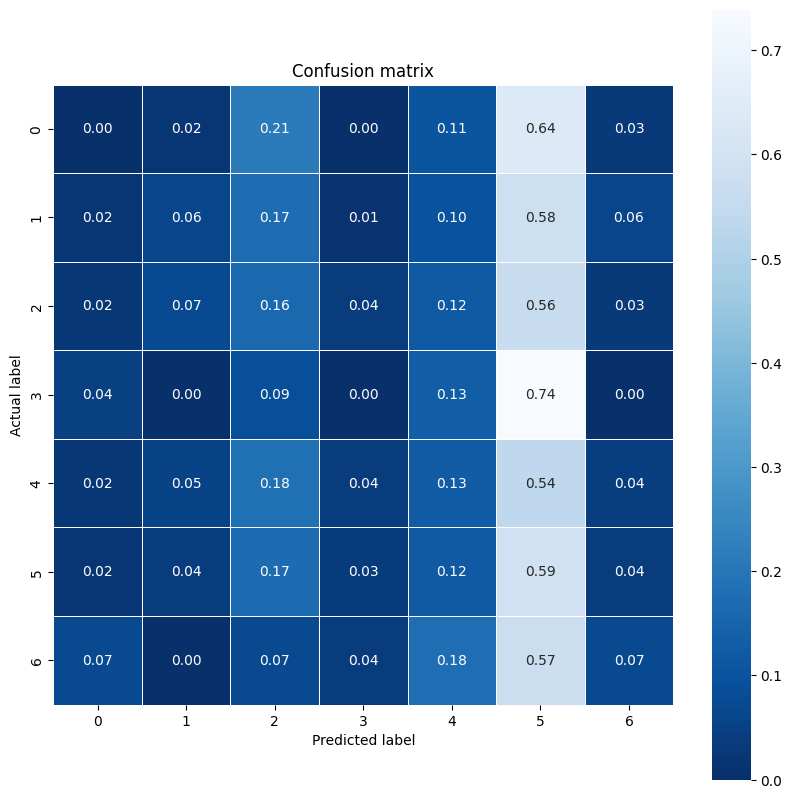

In [11]:
# confusion matrix using model.evaluate
test_generator.reset()
loss, acc = VGG16_model.evaluate(test_generator, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

# confusion matrix using model.predict
test_generator.reset()
y_pred = VGG16_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

from sklearn.metrics import confusion_matrix
import seaborn as sns


In [39]:
cm = confusion_matrix(y_true, y_pred)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [40]:
labels = test_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
labels = [labels[k] for k in range(len(labels))]
print(labels)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [41]:
#replace numerical labels with string labels
cm_df = pd.DataFrame(cm, index = labels, columns = labels)

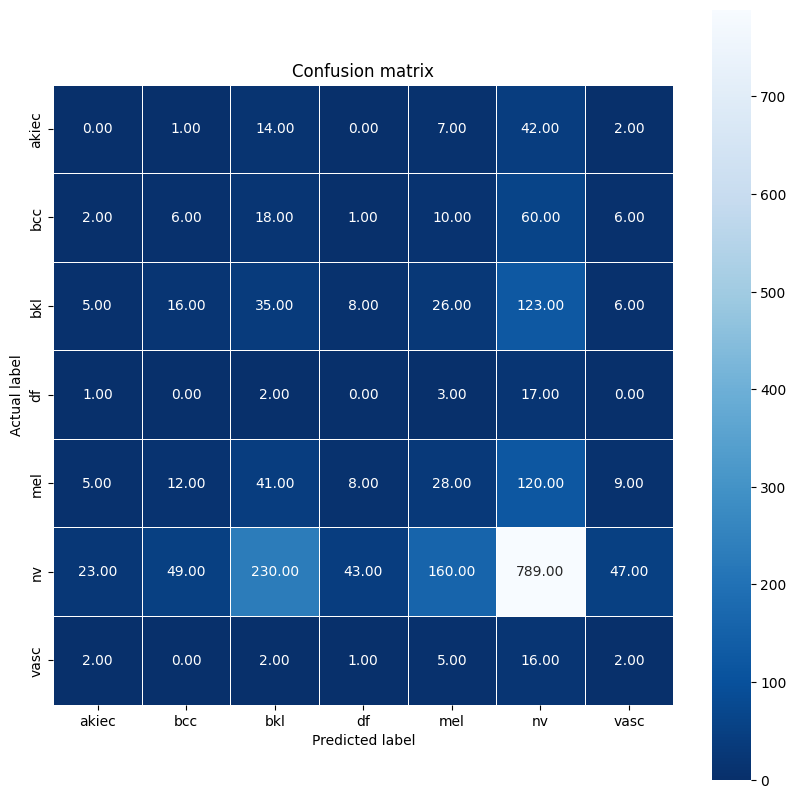

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r', annot_kws={"size": 10})
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
plt.savefig(MODEL_PATH + MODEL_NAME[:-3] + "_confusion_matrix.png")
plt.show()

In [43]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))



              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        66
         bcc       0.07      0.06      0.06       103
         bkl       0.10      0.16      0.12       219
          df       0.00      0.00      0.00        23
         mel       0.12      0.13      0.12       223
          nv       0.68      0.59      0.63      1341
        vasc       0.03      0.07      0.04        28

    accuracy                           0.43      2003
   macro avg       0.14      0.14      0.14      2003
weighted avg       0.48      0.43      0.45      2003

